# **🦠 SARS-CoV-2 Infection Dynamics: Single-Cell Analysis**
This notebook analyzes **SARS-CoV-2 infection dynamics** in human bronchial epithelial cells (HBECs). We will process single-cell RNA-seq data from three timepoints (1, 2, and 3 days post-infection) alongside a Mock control to understand how the tissue responds to the virus over time.

**Key Goals:**

1. Integrate data from 4 different conditions.

2. Identify major airway cell types (Basal, Ciliated, Secretory).

3. Map the differentiation trajectory of stem-like Basal cells at 3dpi.

### **Environment Setup:** 
We begin by importing the necessary libraries. We strictly define our directory paths here to ensure the notebook runs smoothly regardless of where it is saved relative to the data.

In [13]:
# ==========================================
# 1. Setup & Aesthetics
# ==========================================
import os
import warnings
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Clean up the output
warnings.filterwarnings("ignore")
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, facecolor='white', frameon=False, vector_friendly=True)

# Define our workspace
# ".." goes up from 'Stage_Three/notebooks/' to 'Stage_Three/'
BASE_PATH = os.path.join("..", "data", "raw")
FIGURES_PATH = os.path.join("..", "figures", "Project1")
CONDITIONS = ["mock", "1dpi", "2dpi", "3dpi"]

# Ensure figures directory exists
os.makedirs(FIGURES_PATH, exist_ok=True)
sc.settings.figdir = FIGURES_PATH

print(f"✅ Stage Three Environment Ready.")
print(f"📂 Looking for data in: {os.path.abspath(BASE_PATH)}")

✅ Stage Three Environment Ready.
📂 Looking for data in: c:\Users\Opemidimeji\Desktop\HackBio_Internship_SC_RNA-Seq_2025\Stage_Three\data\raw


### **Sequential Data Loading:** 
We are dealing with a large dataset (~70k cells total). Loading all four matrices into memory at once can crash standard laptops (MemoryError).

**Strategy:** We use a Sequential Merge approach.

1. Load one dataset.

2. Tag it with its condition (e.g., "1dpi").

3. Convert it to a memory-efficient sparse format.

4. Merge it into the main object and delete the temporary file immediately.

This ensures we never hold more than two datasets in RAM at any given moment.

In [14]:
import gc 
from scipy import sparse

# ==========================================
# 2. Sequential Data Loading kl8;9'0|=
# ==========================================
adata = None 

print("📂 Starting Sequential Merge...")

for condition in CONDITIONS:
    path = os.path.join(BASE_PATH, condition)
    
    if os.path.exists(path):
        print(f"   🔹 Loading {condition}...", end=" ")
        
        # Load ONE dataset
        current_data = sc.read_10x_mtx(path, var_names='gene_symbols', cache=True)
        
        # 1. Manually Stamp the Condition
        current_data.obs['condition'] = condition
        current_data.var_names_make_unique()
        
        # 2. Filter early to save RAM
        sc.pp.filter_genes(current_data, min_cells=10)
        
        # 3. Ensure Sparse Matrix (Saves Memory)
        if not sparse.issparse(current_data.X):
            current_data.X = sparse.csr_matrix(current_data.X)
        
        print(f"Loaded ({current_data.n_obs} cells). Merging...")
        
        # 4. MERGE LOGIC
        if adata is None:
            adata = current_data
        else: 
            # We already added the 'condition' column manually above.
            # sc.concat will simply stack them and preserve our text labels.
            adata = sc.concat([adata, current_data], join='inner')
            
        # 5. Cleanup
        del current_data
        gc.collect() 
        
    else:
        print(f"   ⚠️ Warning: Path not found: {path}")

# Final Cleanup
adata.obs_names_make_unique()
print(f"🎉 Final Merged Dataset: {adata.n_obs} cells × {adata.n_vars} genes")

# VERIFICATION (Crucial Step)
# This confirms we actually have '3dpi' in the data
print("\n🧐 Verifying Conditions in Dataset:")
print(adata.obs['condition'].value_counts())

📂 Starting Sequential Merge...
   🔹 Loading mock... ... reading from cache file cache\..-data-raw-mock-matrix.h5ad
filtered out 14462 genes that are detected in less than 10 cells
Loaded (22609 cells). Merging...
   🔹 Loading 1dpi... ... reading from cache file cache\..-data-raw-1dpi-matrix.h5ad
filtered out 14101 genes that are detected in less than 10 cells
Loaded (11834 cells). Merging...
   🔹 Loading 2dpi... ... reading from cache file cache\..-data-raw-2dpi-matrix.h5ad
filtered out 13869 genes that are detected in less than 10 cells
Loaded (14695 cells). Merging...
   🔹 Loading 3dpi... ... reading from cache file cache\..-data-raw-3dpi-matrix.h5ad
filtered out 13873 genes that are detected in less than 10 cells
Loaded (28530 cells). Merging...
🎉 Final Merged Dataset: 77668 cells × 18318 genes

🧐 Verifying Conditions in Dataset:
condition
3dpi    28530
mock    22609
2dpi    14695
1dpi    11834
Name: count, dtype: int64


### **Quality Control (QC):** 
Before analysis, we must filter out low-quality cells.

* **Mitochondrial Content (MT):** High levels (>15%) indicate dying cells where the cytoplasm has leaked out, leaving only mitochondrial RNA.

* **Library Size:** Cells with very few genes detected are likely empty droplets or failed sequencing.

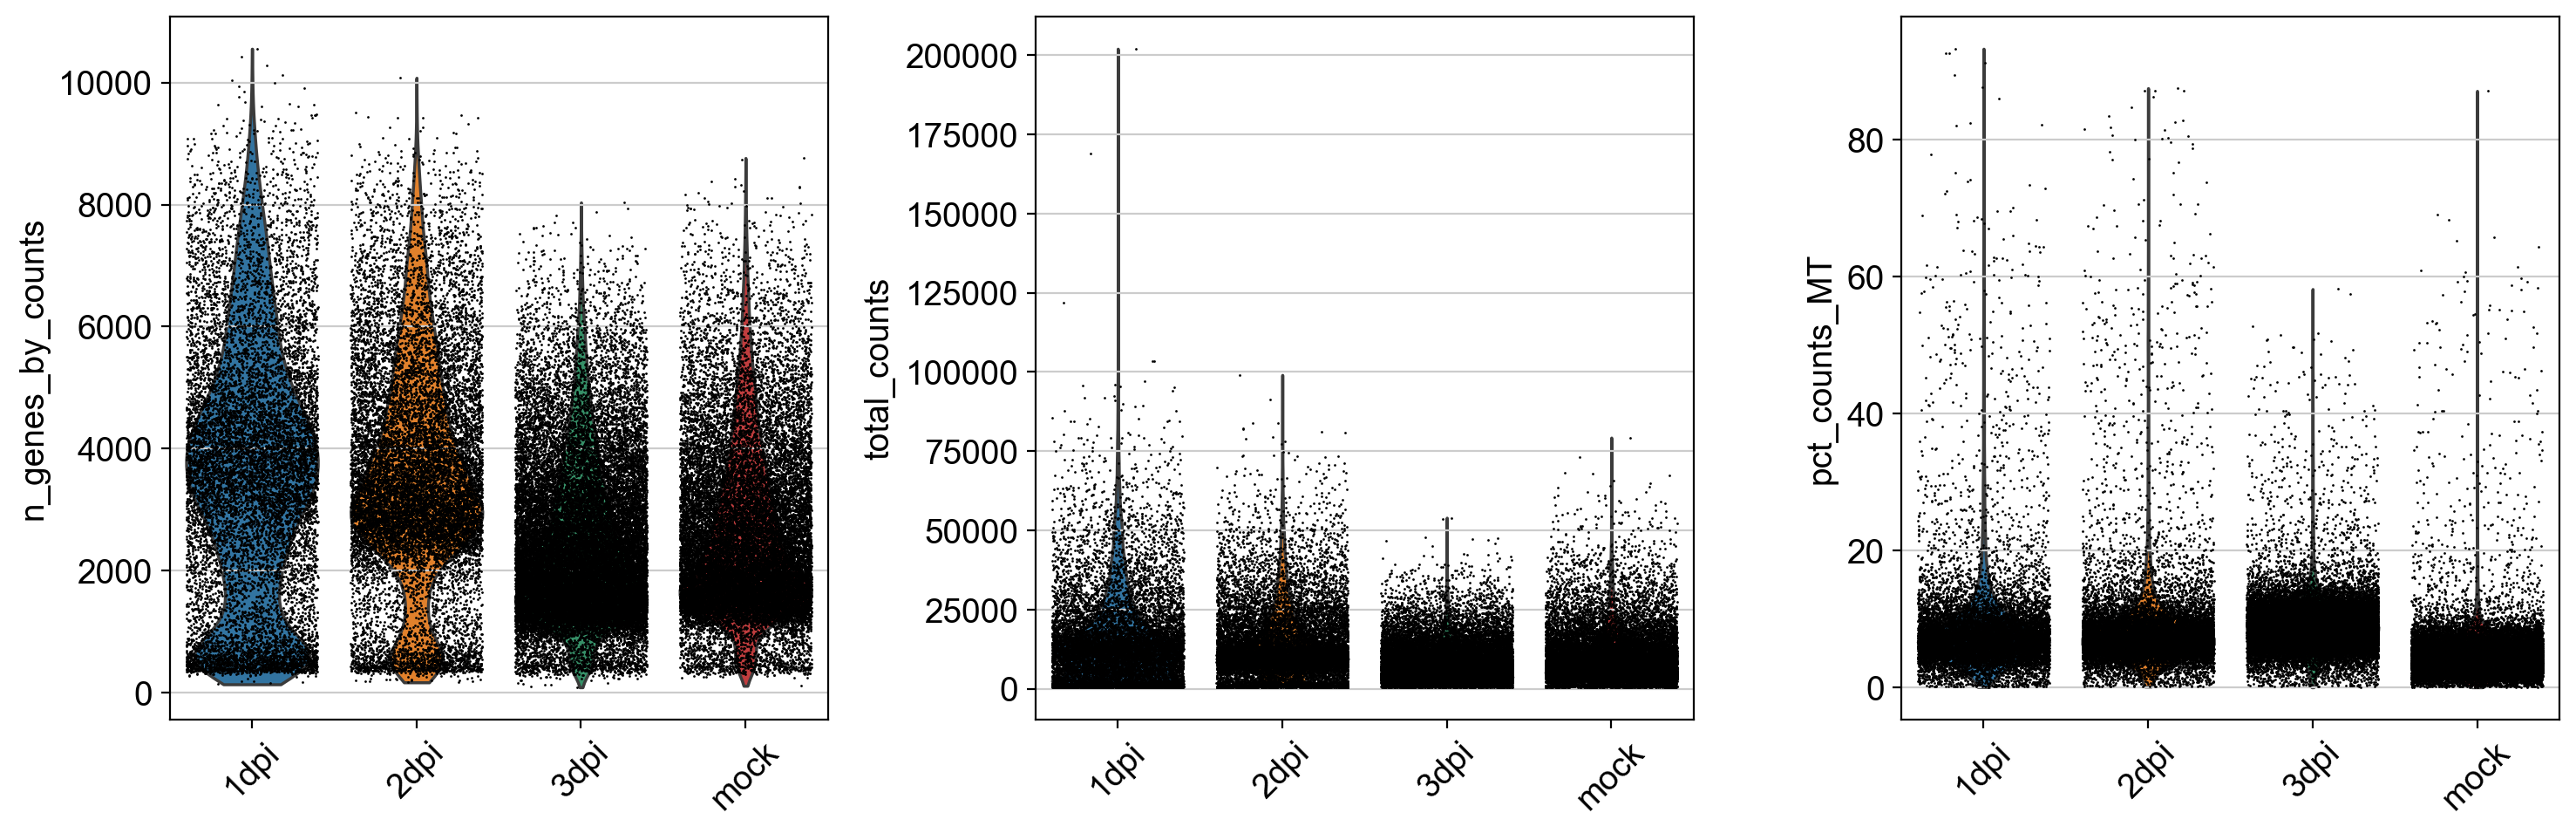

Cells before filtering: 77668
filtered out 18 cells that have less than 200 genes expressed
Cells after filtering: 74315


In [15]:
# ==========================================
# 3. Quality Control
# ==========================================
# Tagging gene groups to check for cell health.

# Mitochondrial (MT): High = Dead/Dying
# Ribosomal (RPS/RPL): High = High metabolic activity
# Hemoglobin (HB): High = Red blood cell contamination
adata.var['MT'] = adata.var_names.str.startswith('MT-')
adata.var['RIBO'] = adata.var_names.str.startswith(('RPS', 'RPL'))
adata.var['HB'] = adata.var_names.str.startswith(('HB', 'HBA', 'HBB'))

# Calculate metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=['MT', 'RIBO', 'HB'], inplace=True, log1p=True)

# Visualize QC
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Genes per cell
sc.pl.violin(adata, 'n_genes_by_counts', groupby='condition', ax=axs[0], show=False, jitter=0.4)
# Plot 2: Total counts
sc.pl.violin(adata, 'total_counts', groupby='condition', ax=axs[1], show=False, jitter=0.4)
# Plot 3: Mitochondrial %
sc.pl.violin(adata, 'pct_counts_MT', groupby='condition', ax=axs[2], show=False, jitter=0.4)

# Formatting: Clean up x-axis labels
for ax in axs:
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('')

plt.tight_layout() # Auto-adjusts spacing
plt.savefig(os.path.join(FIGURES_PATH, "_qc_violin.png"))
plt.show()

# Filtering
# Remove cells with >15% mitochondrial reads (relaxed threshold for infection)
print(f"Cells before filtering: {adata.n_obs}")
sc.pp.filter_cells(adata, min_genes=200)
adata = adata[adata.obs['pct_counts_MT'] < 15, :] 
print(f"Cells after filtering: {adata.n_obs}")

### **Normalization & Feature Selection:** 
To compare gene expression between cells, we must normalize the data so that every cell has the same "library size" (10,000 counts). We then identify Highly Variable Genes (HVGs), the genes that carry the most biological signal, and use PCA to reduce the dataset's complexity.

normalizing counts per cell
    finished (0:01:02)
extracting highly variable genes
    finished (0:07:49)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


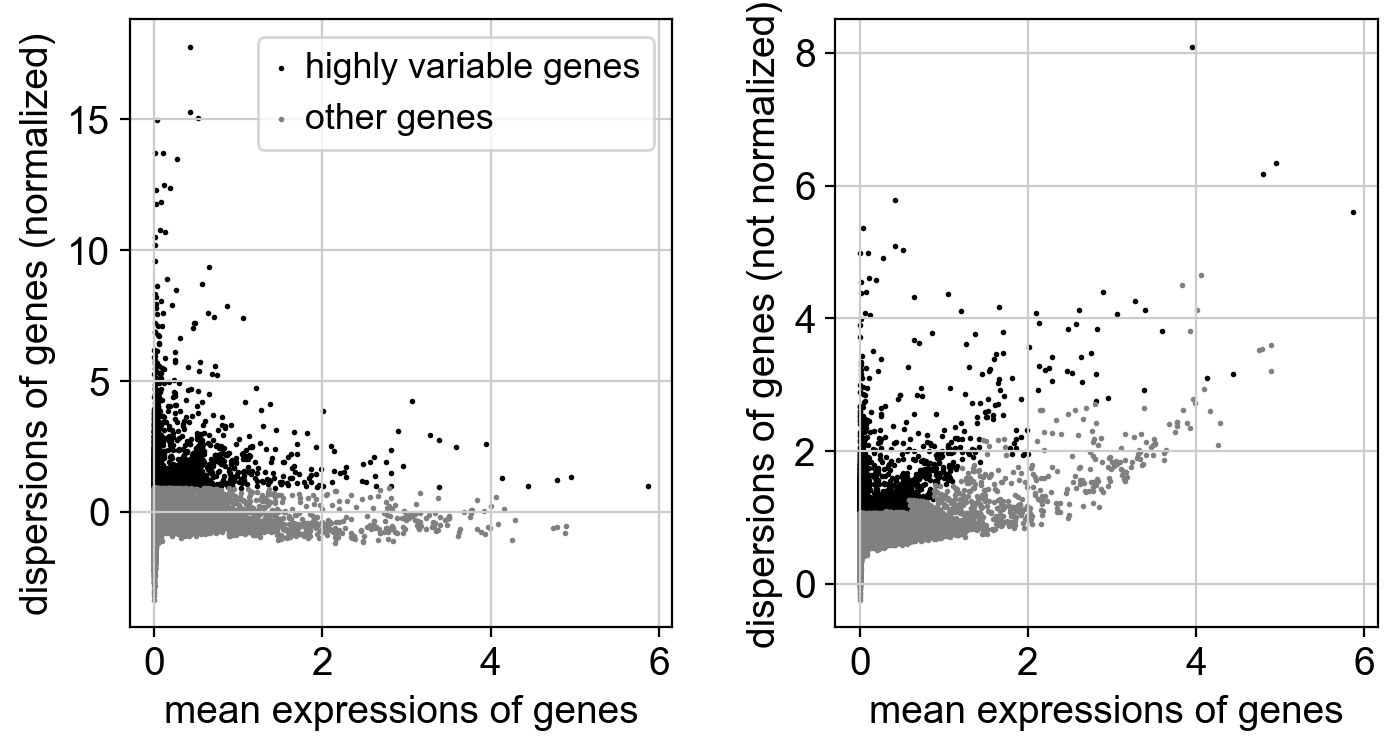

computing PCA
    with n_comps=50
    finished (0:01:12)


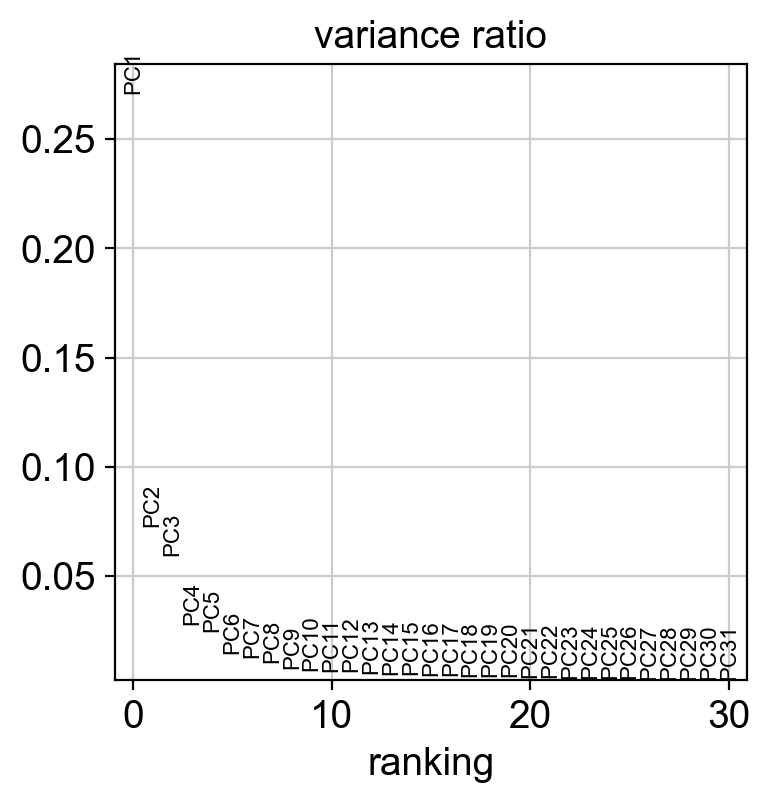

In [16]:
# ==========================================
# 4. Preprocessing (Normalization & PCA)
# ==========================================

# Save raw counts for later
adata.layers['counts'] = adata.X.copy()

# Normalize: Make every cell have the same "library size"
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Highly Variable Genes (HVGs)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=False, flavor="seurat")
sc.pl.highly_variable_genes(adata, save="_dispersion.png")

# PCA: Summarize data into 50 essential components
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=30, save="_variance.png")

### **Dimensionality Reduction & Clustering:** 
We use UMAP to visualize the 70,000 cells in 2D space. Cells with similar expression profiles will group together. We then use Leiden Clustering to mathematically define these groups.

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:03:46)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:05:57)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:01:38)


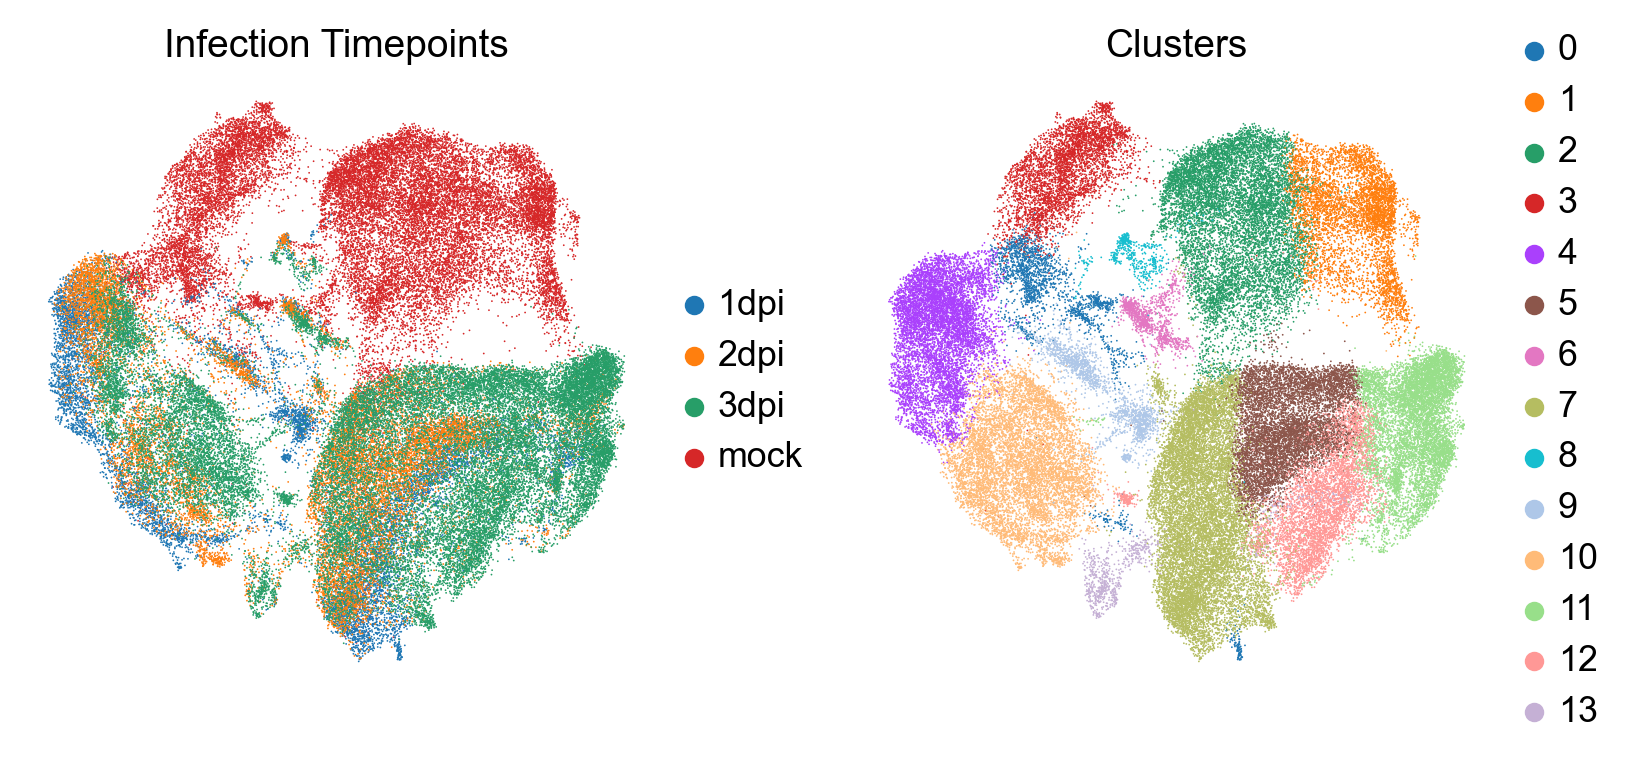

In [17]:
# ==========================================
# 5. Clustering & Embedding
# ==========================================

# Neighborhood Graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# UMAP
sc.tl.umap(adata)

# Leiden Clustering
# Using 'igraph' flavor for speed
sc.tl.leiden(adata, resolution=0.5, flavor="igraph")

# Visualization
sc.pl.umap(
    adata, 
    color=['condition', 'leiden'], 
    title=['Infection Timepoints', 'Clusters'],
    save="_umap_overview.png"
)

### **Manual Cell Type Annotation:** We identify the biological identity of our clusters using canonical marker genes derived from the literature.

* **Basal Cells:** _TP63, KRT5_

* **Ciliated Cells:** _FOXJ1, TP73_

* **Secretory/Club Cells:** _SCGB1A1_

* **Interferon Response:** _IFI27, ISG15_ (Indicates active viral defense)

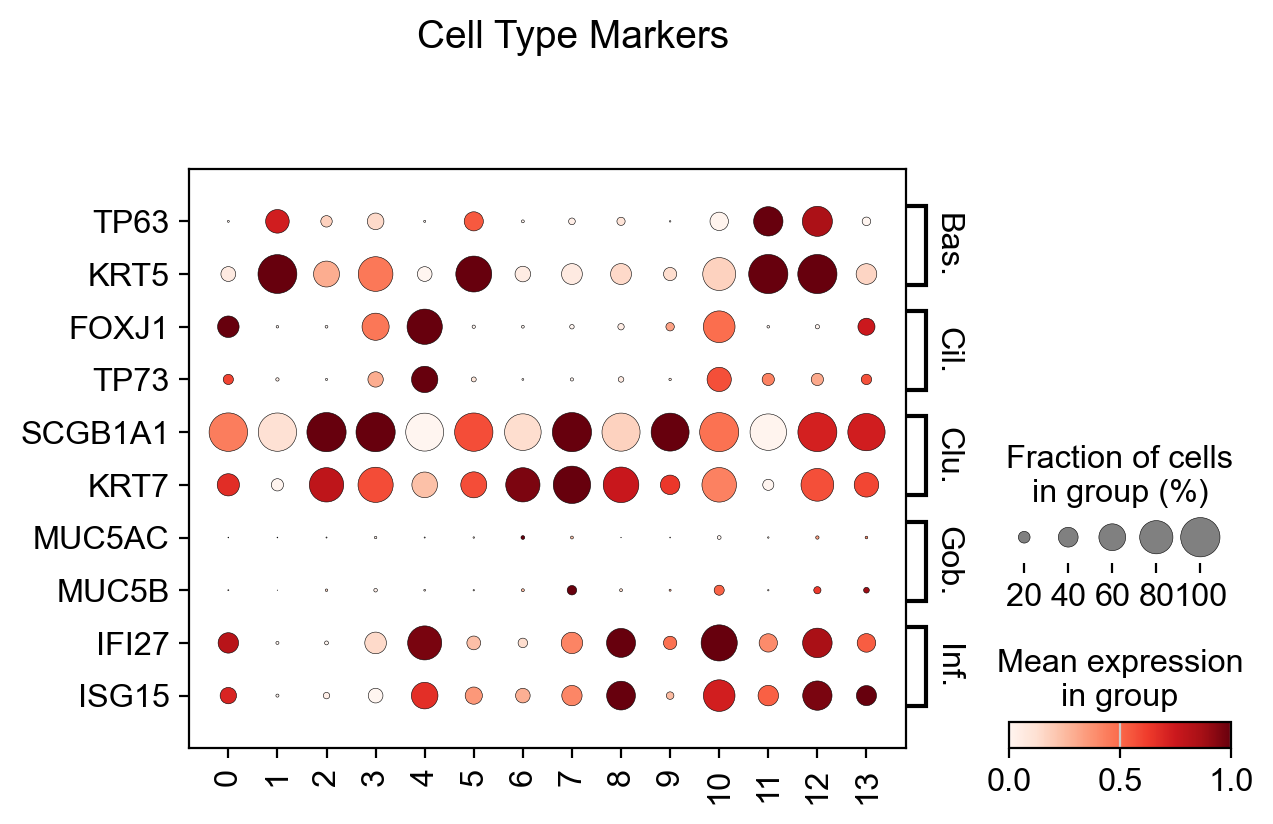

In [18]:
# ==========================================
# 6. Annotation (Manual Validation)
# ==========================================
# We use canonical markers from the reference paper (Ravindra et al.)

marker_dict = {
    "Basal (Stem)": ["TP63", "KRT5"],
    "Ciliated": ["FOXJ1", "TP73"],
    "Club/Secretory": ["SCGB1A1", "KRT7"],
    "Goblet": ["MUC5AC", "MUC5B"],
    "Infected/Stress": ["IFI27", "ISG15"] # Interferon response genes
}

# Filter markers to ensure they exist in our dataset
valid_markers = {k: [g for g in v if g in adata.var_names] for k, v in marker_dict.items()}

# Plotting with swap_axes=True to fix title overlap
sc.pl.dotplot(
    adata, 
    valid_markers, 
    groupby='leiden', 
    standard_scale='var', 
    swap_axes=True, # Moves gene names to Y-axis to prevent title overlap
    title="Cell Type Markers",
    save="_markers_dotplot.png"
)

# Note: Based on this Dotplot, you will manually map names to clusters.
# For example, if Cluster 0 has high TP63/KRT5, it is Basal.
# adata.obs['cell_type'] = adata.obs['leiden'].map({'0': 'Basal', '1': 'Ciliated', ...})

### **Trajectory Analysis (3dpi):** 
To understand how the tissue regenerates, we model the differentiation trajectory at 3 days post-infection. We use Diffusion Pseudotime (DPT), setting the stem-like Basal cells as the starting point (root). 
The resulting plot will color cells by "pseudotime," showing the progression from stem cells (dark blue) to differentiated cells (yellow).


⏳ Running Trajectory Analysis on 3dpi...


computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:02:10)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9974834  0.99205    0.9896047  0.98838806 0.98706657
     0.98434263 0.976921   0.97070646 0.9642299  0.96350324 0.9633032
     0.9621301  0.9597039  0.95809746]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:06)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


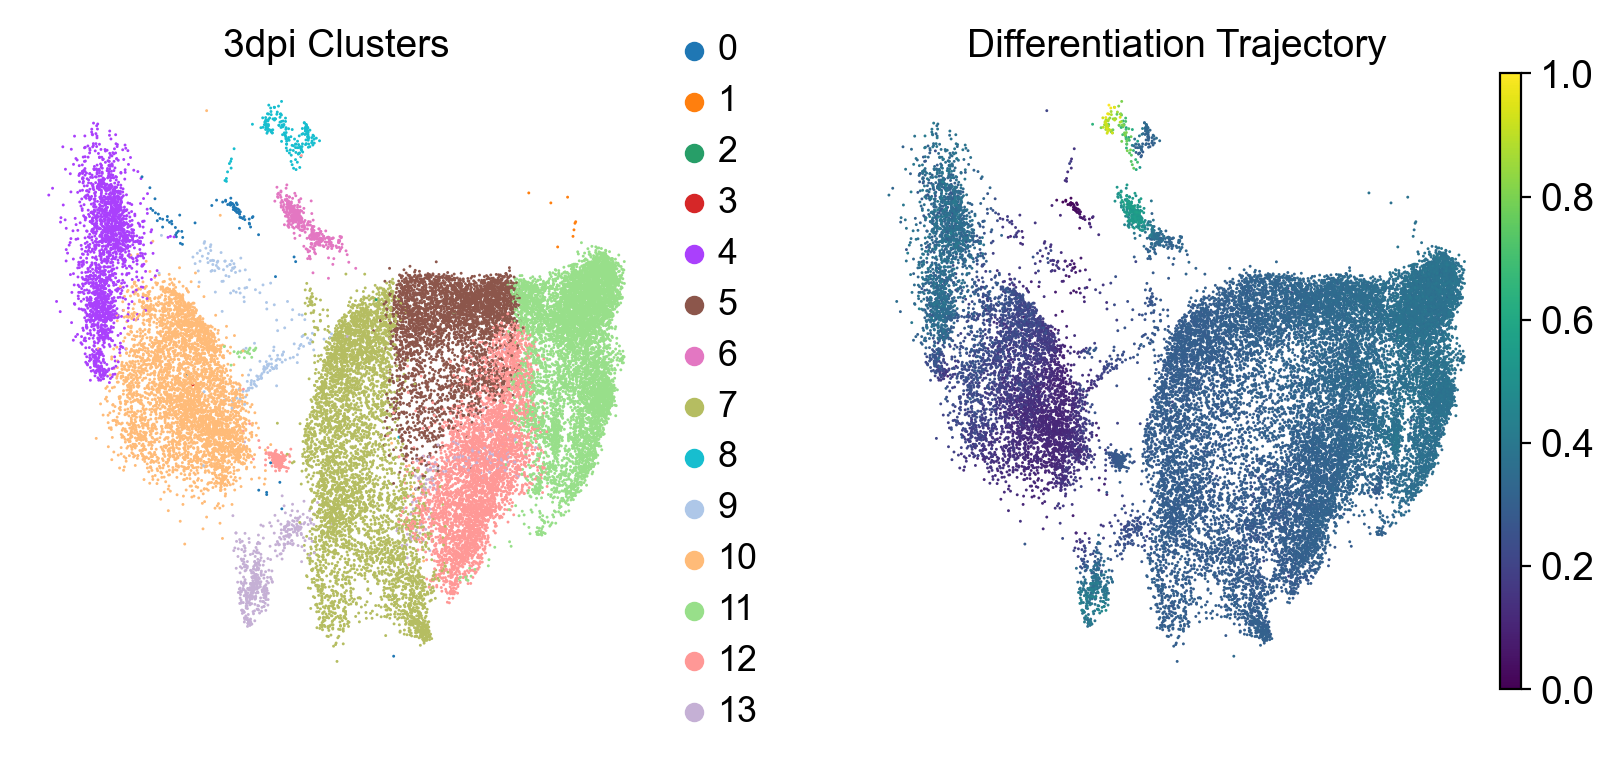

✅ Analysis Complete.


In [19]:
# ==========================================
# 7. Pseudotime Analysis (3dpi Only)
# ==========================================
# Differentation trajectory on 3dpi.

print("\n⏳ Running Trajectory Analysis on 3dpi...")

# 1. Subset the data
adata_3 = adata[adata.obs['condition'] == '3dpi'].copy()

# 2. Re-compute neighbors (Trajectory needs a clean graph of just these cells)
sc.pp.neighbors(adata_3, n_neighbors=15, n_pcs=40)
sc.tl.diffmap(adata_3)

# 3. Define the "Root" (Start of time)
# Biologically, Basal cells are the progenitors. 
# We pick a cell in the 'Basal' cluster (Cluster 0 usually) to be the seed.
# CRITICAL: Verify Cluster 0 is Basal in your dotplot!
root_cluster = '0' 
root_id = np.flatnonzero(adata_3.obs['leiden'] == root_cluster)[0]
adata_3.uns['iroot'] = root_id

# 4. Calculate Diffusion Pseudotime (DPT)
sc.tl.dpt(adata_3)

# 5. Visualize
# Cells colored by DPT show the flow from Start (dark blue) to End (yellow)
sc.pl.umap(
    adata_3, 
    color=['leiden', 'dpt_pseudotime'], 
    color_map='viridis', 
    title=['3dpi Clusters', 'Differentiation Trajectory'],
    save="_trajectory_3dpi.png"
)

print("✅ Analysis Complete.")